<a href="https://colab.research.google.com/github/Josfel03/flask-whisper-transcription/blob/main/AnalisisSentimientos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTALACIÓN DE LAS DEPENDENCIAS


In [25]:
!pip install transformers ftfy pandas matplotlib seaborn numpy transformers tqdm  matplotlib seaborn wordcloud nltk spacy

#IMPORTACION DE BIBLIOTECAS

In [26]:
# Importar las bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from ftfy import fix_text
import numpy as np
import warnings
from google.colab import files
from tqdm.notebook import tqdm

# Importaciones para procesamiento de texto
import nltk
import spacy
import string
import unicodedata
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Importaciones para TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Importaciones para visualización del progreso
from tqdm.notebook import tqdm

# Descarga de recursos necesarios (ejecutar solo una vez)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Cargar modelo de spaCy para español
# Instalar modelo más grande si es necesario
try:
    nlp = spacy.load('es_core_news_md')
except:
    print("Instalando modelo más grande de spaCy para español...")
    import os
    os.system('python -m spacy download es_core_news_md')
    nlp = spacy.load('es_core_news_md')
# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Configurar estilo de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

#PREPROCESAMIENTO Y LIMPIEZA DEL TEXTO

In [48]:
# === BLOQUE 1: PREPROCESAMIENTO Y LIMPIEZA DE TEXTO AVANZADA ===

def lematizar_personalizado(palabra):
    """
    Lematizador personalizado para mejorar casos específicos en español

    Args:
        palabra (str): Palabra a lematizar

    Returns:
        str: Lema de la palabra
    """
    # Verbos con irregularidades comunes
    mapeo_verbos = {
        'sentiria': 'sentir',
        'sentirias': 'sentir',
        'confiaria': 'confiar',
        'confiarias': 'confiar',
        'confiaramos': 'confiar',
        'confiarian': 'confiar',
        'sentiriamos': 'sentir',
        'sentirian': 'sentir',
        'gustaria': 'gustar',
        'gustarias': 'gustar',
        'gustariamos': 'gustar',
        'gustarian': 'gustar',
        'deberia': 'deber',
        'deberias': 'deber',
        'deberiamos': 'deber',
        'deberian': 'deber',
        'podria': 'poder',
        'podrias': 'poder',
        'podriamos': 'poder',
        'podrian': 'poder',
        'tendria': 'tener',
        'tendrias': 'tener',
        'tendriamos': 'tener',
        'tendrian': 'tener',
        'queria': 'querer',
        'querias': 'querer',
        'estaria' : 'estar',
        'estarias': 'estar',
        'estariamos': 'estar',
        'estarian': 'estar',
        'invadido' : 'invadir'
        # Puedes seguir añadiendo más casos específicos según los encuentres
    }

    # Verificar si la palabra está en el mapeo de verbos
    if palabra in mapeo_verbos:
        return mapeo_verbos[palabra]

    # Reglas para verbos regulares
    if len(palabra) > 4:
        # Infinitivos (ya están en forma base)
        if palabra.endswith('ar') or palabra.endswith('er') or palabra.endswith('ir'):
            return palabra

        # Conjugaciones comunes
        terminaciones = [
            ('aba', 'ar'), ('abas', 'ar'), ('abamos', 'ar'), ('aban', 'ar'),  # imperfecto -ar
           ( 'ir'), ('ias', 'ir'), ('iamos', 'ir'), ('ian', 'ir'),      # imperfecto -er/-ir
            ('are', 'ar'), ('ares', 'ar'), ('aremos', 'ar'), ('aren', 'ar'),  # futuro subjuntivo -ar
            ('iere', 'er'), ('ieres', 'er'), ('ieremos', 'er'), ('ieren', 'er'),  # futuro subjuntivo -er/-ir
            ('aria', 'ar'), ('arias', 'ar'), ('ariamos', 'ar'), ('arian', 'ar'),  # condicional -ar
            ('eria', 'er'), ('erias', 'er'), ('eriamos', 'er'), ('erian', 'er'),  # condicional -er
            ('iria', 'ir'), ('irias', 'ir'), ('iriamos', 'ir'), ('irian', 'ir'),  # condicional -ir
            ('ando', 'ar'),  # gerundio -ar
            ('iendo', 'er'), ('iendo', 'ir'),  # gerundio -er/-ir
            ('ado', 'ar'),  # participio -ar
            ('ido', 'er'), ('ido', 'ir')      # participio -er/-ir
        ]

        for term, repl in terminaciones:
            if palabra.endswith(term):
                raiz = palabra[:-len(term)]
                # Verificar si hay verbos específicos (sentir, mentir, etc.)
                if repl == 'er' and raiz + 'ir' in ['sent', 'ment', 'dorm', 'part']:
                    return raiz + 'ir'
                return raiz + repl

    # Si no se aplicó ninguna regla, devolvemos la palabra original
    # (spaCy se encargará de lematizarla más adelante)
    return palabra

def limpieza_completa(texto, eliminar_stopwords=False):
    """
    Función completa de limpieza de texto optimizada con lematización personalizada

    Args:
        texto (str): Texto a limpiar
        eliminar_stopwords (bool): Si se deben eliminar stopwords (False por defecto para BERT)

    Returns:
        str: Texto limpio procesado
    """
    if pd.isna(texto) or texto.strip() == "":
        return ""

    try:
        # Convertir a minúsculas
        texto = texto.lower()

        # Quitar tildes
        texto = unicodedata.normalize('NFD', texto).encode('ascii', 'ignore').decode('utf-8')

        # Quitar puntuación y caracteres especiales
        texto = ''.join(ch for ch in texto if ch not in string.punctuation and ch not in '¿¡""''')

        # Quitar números
        texto = ''.join(ch for ch in texto if not ch.isdigit())

        # Quitar espacios múltiples
        texto = ' '.join(texto.split())

        # Para BERT es mejor no eliminar stopwords ni hacer lematización
        if not eliminar_stopwords:
            return texto

        # Lista personalizada de stopwords adicionales
        stopwords_adicionales = {
            'pues', 'si', 'vez', 'veces', 'aqui', 'ahi', 'alla', 'cada', 'aunque',
            'asi', 'tan', 'tal', 'como', 'donde', 'cuando', 'quien', 'quienes',
            'cual', 'cuales', 'cuanto', 'cuanta', 'cuantos', 'cuantas', 'todo',
            'todos', 'toda', 'todas', 'otro', 'otra', 'otros', 'otras', 'mucho',
            'muchos', 'mucha', 'muchas', 'poco', 'pocos', 'poca', 'pocas', 'algo', 'alguien',
            'bien', 'mal', 'mejor', 'peor', 'menos', 'mas', 'además', 'tambien', 'siempre', 'nunca',
            'ahora', 'entonces', 'luego', 'despues', 'antes', 'durante', 'mediante', 'segun', 'porque',
            'pues', 'pero', 'sin', 'con', 'contra', 'entre', 'hasta', 'desde', 'sobre', 'tras',
            'hacia', 'para', 'por', 'muy', 'casi', 'apenas', 'solo', 'ya', 'puede', 'puedo', 'pueden',
            'ser', 'estar', 'tener', 'hacer', 'decir', 'ir', 'ver', 'dar', 'haber', 'poder',
            'poner', 'saber', 'querer', 'deber', 'parecer', 'inteligencia artificial', 'inteligencia', 'artificial'
        }

        # Combinar con stopwords estándar
        stop_words = set(stopwords.words('spanish')).union(stopwords_adicionales)

        # Tokenizar el texto
        palabras = texto.split()

        # Aplicar lematización personalizada primero
        palabras_lematizadas = [lematizar_personalizado(palabra) for palabra in palabras]

        # Procesar con spaCy para mejorar la lematización general
        doc = nlp(' '.join(palabras_lematizadas))

        # Combinar ambos enfoques y filtrar stopwords
        lemmas = []
        for token in doc:
            # Verificar si es un stopword
            if token.text in stop_words:
                continue

            # Obtener el lema mejorado
            lema = token.lemma_.lower().strip()

            # Filtrar lemas vacíos o muy cortos
            if lema and len(lema) > 1:
                lemmas.append(lema)

        # Unir los lemas en un string
        resultado = ' '.join(lemmas)

        return resultado

    except Exception as e:
        print(f"Error procesando texto: {e}")
        return texto

def generar_matriz_tfidf(textos_procesados):
    """
    Genera matriz TF-IDF a partir de textos procesados

    Args:
        textos_procesados (list): Lista de textos procesados

    Returns:
        tuple: (matriz_tfidf, vectorizador)
    """
    # Crear vectorizador TF-IDF con configuración optimizada
    vectorizador = TfidfVectorizer(
        max_features=5000,  # Limitar a 5000 palabras más relevantes
        min_df=2,           # Ignorar palabras que aparecen en menos de 2 documentos
        max_df=0.95,        # Ignorar palabras que aparecen en más del 95% de los documentos
        ngram_range=(1, 2)  # Incluir unigramas y bigramas
    )

    # Generar matriz TF-IDF
    matriz_tfidf = vectorizador.fit_transform(textos_procesados)

    return matriz_tfidf, vectorizador

#CARGA Y LIMPIEZA DE DATOS

In [28]:
def cargar_datos(ruta_archivo=None):
    """
    Carga datos desde un archivo CSV subido o solicita una subida

    Args:
        ruta_archivo (str, opcional): Ruta al archivo CSV. Si es None, solicita carga.

    Returns:
        pandas.DataFrame: Datos cargados del CSV
    """
    try:
        if ruta_archivo is None:
            # Solicitar al usuario que suba el archivo
            print("Por favor, sube tu archivo CSV de respuestas:")
            uploaded = files.upload()
            ruta_archivo = list(uploaded.keys())[0]  # Tomar el primer archivo subido

        # Leer el archivo CSV
        df = pd.read_csv(ruta_archivo)

        # Limpiar nombres de columnas (quitar espacios)
        df.columns = df.columns.str.strip()

        # Verificar la existencia de la columna de respuestas
        if 'RESPUESTA' not in df.columns:
            print("Advertencia: No se encontró la columna 'RESPUESTA'. Asegúrate que el archivo contenga esta columna.")

        print(f"Datos cargados exitosamente: {len(df)} filas")
        print(f"Columnas encontradas: {list(df.columns)}")

        return df
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return None

def limpiar_texto(df):
    """
    Limpia y prepara el texto de las respuestas para análisis

    Args:
        df (pandas.DataFrame): DataFrame con columna 'RESPUESTA'

    Returns:
        pandas.DataFrame: DataFrame con texto limpio
    """
    # Verificar que exista la columna RESPUESTA
    if 'RESPUESTA' not in df.columns:
        print("Error: No se encontró la columna RESPUESTA")
        return df

    # Convertir a string y arreglar problemas de codificación
    df["RESPUESTA"] = df["RESPUESTA"].apply(lambda x: fix_text(str(x)) if pd.notna(x) else "")

    # Eliminar registros vacíos o nulos
    vacios_antes = df['RESPUESTA'].isna().sum() + (df['RESPUESTA'] == "").sum()
    df = df[df['RESPUESTA'].notna() & (df['RESPUESTA'] != "")]
    vacios_despues = df['RESPUESTA'].isna().sum() + (df['RESPUESTA'] == "").sum()

    print(f"Registros vacíos eliminados: {vacios_antes - vacios_despues}")

    return df

#ANÁLISIS DE SENTIMINETOS CON TRES POLARIDADES

In [29]:
def analizar_sentimiento_tres_polaridades(df):
    """
    Analiza el sentimiento de las respuestas y lo clasifica en tres categorías:
    positivo, negativo y neutro

    Args:
        df (pandas.DataFrame): DataFrame con columna 'RESPUESTA'

    Returns:
        pandas.DataFrame: DataFrame con columnas de sentimiento añadidas
    """
    print("Limpiando textos y preparando para análisis...")

    # AGREGAR ESTA SECCIÓN: Aplicar limpieza de texto
    df["RESPUESTA_LIMPIA"] = df["RESPUESTA"].apply(lambda x: limpieza_completa(str(x), eliminar_stopwords=False))

    print("Cargando modelo BERT multilingüe para análisis de sentimiento...")

    # Cargar el modelo de análisis de sentimientos
    classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

    # MODIFICAR ESTA SECCIÓN: Actualizar mapeo para tres polaridades
    # Mapeo directo de estrellas a tres polaridades
    mapeo_polaridad = {
        "1 star": "negativo",
        "2 stars": "negativo",
        "3 stars": "neutro",
        "4 stars": "positivo",
        "5 stars": "positivo"
    }

    # MODIFICAR ESTA SECCIÓN: Actualizar valores de rank para usar solo 1-2-3
    # Valor numérico para mantener compatibilidad con visualizaciones
    valor_estrellas = {
        "1 star": 1,     # negativo
        "2 stars": 2,    # neutro
        "3 stars": 3,    # positivo
        "4 stars": 4,    # positivo (mapear a 3)
        "5 stars": 5     # positivo (mapear a 3)
    }

    def predecir_sentimiento(texto):
        """
        Predice el sentimiento de un texto usando el modelo BERT
        y lo convierte directamente a una de tres categorías
        """
        if pd.isna(texto) or texto.strip() == "":
            return {"sentimiento": "No disponible", "rank": None}
        try:
            # Obtener predicción del modelo y mapear directamente
            resultado = classifier(texto)[0]["label"]
            return {
                "sentimiento": mapeo_polaridad.get(resultado, "No disponible"),
                "rank": valor_estrellas.get(resultado)
            }
        except Exception as e:
            print(f"Error con texto: {texto[:30]}... -> {e}")
            return {"sentimiento": "Error", "rank": None}

    print("Analizando sentimientos de las respuestas... (puede tardar varios minutos)")

    # MODIFICAR ESTA LÍNEA: Usar texto limpio en lugar del original
    # Aplicar el análisis a cada respuesta con barra de progreso
    tqdm.pandas(desc="Procesando")
    resultados = df["RESPUESTA_LIMPIA"].progress_apply(predecir_sentimiento)

    # Extraer resultados al DataFrame (solo sentimiento y rank)
    df["sentimiento_predicho"] = resultados.apply(lambda x: x["sentimiento"])
    df["rank"] = resultados.apply(lambda x: x["rank"])

    print("Análisis de sentimiento completado")

    # AGREGAR ESTA SECCIÓN: Procesamiento para TF-IDF
    print("Generando representación TF-IDF para análisis adicionales...")
    df["texto_tfidf"] = df["RESPUESTA"].apply(lambda x: limpieza_completa(str(x), eliminar_stopwords=True))
    textos_procesados = df["texto_tfidf"].tolist()

    # Generar matriz TF-IDF
    matriz_tfidf, vectorizador = generar_matriz_tfidf(textos_procesados)

    # Guardar vectorizador y matriz como atributos del DataFrame
    df.attrs['vectorizador_tfidf'] = vectorizador
    df.attrs['matriz_tfidf'] = matriz_tfidf

    return df

#VISUALIZACION DE SENTIMIENTOS

In [30]:
def visualizar_sentimientos(df, incluir_neutro=False):
    """
    Genera visualizaciones para los sentimientos detectados

    Args:
        df (pandas.DataFrame): DataFrame con columna 'sentimiento_predicho'
        incluir_neutro (bool): Si se deben incluir sentimientos neutros
    """
    if 'sentimiento_predicho' not in df.columns:
        print("Error: No se encuentra la columna 'sentimiento_predicho'")
        return

    # Filtrar datos según la preferencia de incluir neutros o no
    if not incluir_neutro:
        df_viz = df[df['sentimiento_predicho'].isin(['positivo', 'negativo'])]
        titulo_extra = " (excluyendo neutros)"
    else:
        df_viz = df
        titulo_extra = ""

    if len(df_viz) == 0:
        print("No hay datos para visualizar con los filtros actuales")
        return

    # Conteo de sentimientos
    sentimientos = df_viz['sentimiento_predicho'].value_counts()

    # Crear figura con subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Definir colores por sentimiento (solo 3 categorías)
    color_map = {'positivo': '#4CAF50', 'negativo': '#F44336', 'neutro': '#9E9E9E'}
    colors = [color_map.get(s, '#9E9E9E') for s in sentimientos.index]

    # 1. Gráfica de barras
    bars = ax1.bar(sentimientos.index, sentimientos.values, color=colors)
    ax1.set_title(f'Distribución de Sentimientos{titulo_extra}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Sentimiento')
    ax1.set_ylabel('Cantidad de Opiniones')

    # Agregar valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

    # 2. Gráfica de pastel
    wedges, texts, autotexts = ax2.pie(
        sentimientos.values,
        labels=sentimientos.index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    ax2.set_title(f'Proporción de Sentimientos{titulo_extra}', fontsize=14, fontweight='bold')

    # Mejorar apariencia del pie chart
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

    # Mostrar estadísticas
    total = len(df_viz)
    print(f"\nEstadísticas de sentimientos{titulo_extra}:")
    print("-" * 40)
    for sent, count in sentimientos.items():
        porcentaje = (count/total)*100
        print(f"{sent.capitalize()}: {count} ({porcentaje:.1f}%)")

    return df_viz

#CONTABILIZACIÓN DE ESTRELLAS

In [31]:
def contabilizar_estrellas(df):
    """
    Contabiliza y analiza las respuestas por número de estrellas basándose en el ranking.

    Args:
        df (pandas.DataFrame): DataFrame que contiene la columna 'rank' con los valores de estrellas

    Returns:
        pandas.Series: Conteo de estrellas ordenado por índice
    """
    # Verificar si existe la columna necesaria
    if 'rank' not in df.columns:
        print("No se encuentra la columna 'rank' para el análisis de estrellas")
        return None

    # Cabecera de la sección
    print("\n" + "="*50)
    print("ANÁLISIS DE ESTRELLAS")
    print("="*50)

    # Conteo por estrella (ordenado por número de estrellas)
    estrellas_count = df['rank'].value_counts().sort_index()
    total_respuestas = len(df)

    # Mostrar estadísticas generales
    print(f"Total de respuestas: {total_respuestas}")
    print("\nDistribución por estrellas:")
    print("-" * 40)

    # Mostrar distribución detallada con estrellas visuales
    for estrella in sorted(estrellas_count.index):
        cantidad = estrellas_count[estrella]
        porcentaje = (cantidad / total_respuestas) * 100
        # Representación visual con emoji de estrella
        estrellas_visual = "⭐" * int(estrella)
        print(f"{int(estrella)} estrella{'s' if int(estrella) != 1 else ''} {estrellas_visual}: "
              f"{cantidad:4d} ({porcentaje:5.1f}%)")

    # Crear visualización con 3 gráficos en una fila
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    ax1, ax2, ax3 = axes  # Desempacar los ejes para mayor claridad

    # Definir colores para las estrellas (de menor a mayor valoración)
    colors = ['#ff4444', '#ff8800', '#ffcc00', '#88cc00', '#00cc44']

    # 1. Gráfica de barras simple
    bars = ax1.bar(
        estrellas_count.index,
        estrellas_count.values,
        color=[colors[min(int(x)-1, 4)] for x in estrellas_count.index]  # Asigna color según valor
    )
    ax1.set_title('Distribución de Calificaciones por Estrellas', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Número de Estrellas')
    ax1.set_ylabel('Cantidad de Respuestas')
    ax1.set_xticks(sorted(estrellas_count.index))

    # Agregar valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.5,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold'
        )

    # 2. Gráfica de pastel
    wedges, texts, autotexts = ax2.pie(
        estrellas_count.values,
        labels=[f'{int(x)}⭐' for x in estrellas_count.index],
        autopct='%1.1f%%',
        colors=[colors[min(int(x)-1, 4)] for x in estrellas_count.index],
        startangle=90
    )
    ax2.set_title('Proporción de Calificaciones', fontweight='bold', fontsize=12)

    # Mejorar apariencia del pie chart (texto más visible)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    # 3. Gráfica horizontal con porcentajes
    y_pos = np.arange(len(estrellas_count))  # Usar numpy para mayor eficiencia
    bars_h = ax3.barh(
        y_pos,
        estrellas_count.values,
        color=[colors[min(int(x)-1, 4)] for x in estrellas_count.index]
    )
    ax3.set_title('Distribución Horizontal con Porcentajes', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Cantidad de Respuestas')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([f'{int(x)} ⭐' for x in estrellas_count.index])

    # Agregar porcentajes a las barras horizontales
    for bar in bars_h:
        width = bar.get_width()
        porcentaje = (width / total_respuestas) * 100
        ax3.text(
            width + 0.5,
            bar.get_y() + bar.get_height()/2,
            f'{int(width)} ({porcentaje:.1f}%)',
            ha='left', va='center', fontweight='bold'
        )

    # Ajustar espaciado entre subgráficos
    plt.tight_layout()
    plt.show()

    # Análisis estadístico adicional
    print(f"\nAnálisis adicional:")
    print("-" * 40)

    # Calcular métricas de tendencia central
    promedio_estrellas = df['rank'].mean()
    mediana_estrellas = df['rank'].median()
    print(f"Promedio de estrellas: {promedio_estrellas:.2f}")
    print(f"Mediana de estrellas: {mediana_estrellas:.1f}")

    # Categorizar las calificaciones para análisis simplificado
    excelentes = len(df[df['rank'] >= 4])  # 4-5 estrellas
    buenas = len(df[df['rank'] == 3])      # 3 estrellas
    malas = len(df[df['rank'] <= 2])       # 1-2 estrellas

    print(f"\nCategorización:")
    print(f"Excelentes (4-5 ⭐): {excelentes} ({(excelentes/total_respuestas)*100:.1f}%)")
    print(f"Regulares (3 ⭐): {buenas} ({(buenas/total_respuestas)*100:.1f}%)")
    print(f"Malas (1-2 ⭐): {malas} ({(malas/total_respuestas)*100:.1f}%)")

    # Análisis cruzado con sentimiento si está disponible
    if 'sentimiento_predicho' in df.columns:
        print(f"\nRelación Estrellas vs Sentimiento:")
        print("-" * 40)
        # Crear tabla cruzada y mostrarla
        crosstab = pd.crosstab(df['rank'], df['sentimiento_predicho'], margins=True)
        print(crosstab)

    return estrellas_count

#ANALISIS DE LA MATRIZ TF-IDF

In [32]:
# === BLOQUE 7: ANÁLISIS AVANZADO CON TF-IDF ===

def identificar_palabras_clave_por_sentimiento(df, columna_sentimiento='sentimiento_predicho', n_palabras=10):
    """
    Identifica las palabras más características para cada categoría de sentimiento
    usando TF-IDF

    Args:
        df (pandas.DataFrame): DataFrame con textos y sentimientos
        columna_sentimiento (str): Nombre de la columna con los sentimientos
        n_palabras (int): Número de palabras clave a extraer

    Returns:
        dict: Diccionario con palabras clave por categoría
    """
    import numpy as np

    # Verificar si se han calculado los atributos de TF-IDF
    if 'vectorizador_tfidf' not in df.attrs or 'matriz_tfidf' not in df.attrs:
        print("Error: Primero debe ejecutar analizar_sentimiento_tres_polaridades")
        return None

    vectorizador = df.attrs['vectorizador_tfidf']
    matriz_tfidf = df.attrs['matriz_tfidf']

    # Agrupar por sentimiento
    sentimientos = df[columna_sentimiento].unique()
    palabras_clave = {}

    # Para cada sentimiento, encontrar las palabras más representativas
    for sentimiento in sentimientos:
        if sentimiento == "No disponible" or sentimiento == "Error":
            continue

        # Filtrar índices por sentimiento
        indices = df.index[df[columna_sentimiento] == sentimiento].tolist()

        if len(indices) == 0:
            continue

        # Extraer submatriz correspondiente a este sentimiento
        X_sentimiento = matriz_tfidf[indices]

        # Calcular promedios de TF-IDF por palabra
        feature_names = vectorizador.get_feature_names_out()
        tfidf_mean = np.array(X_sentimiento.mean(axis=0)).flatten()

        # Ordenar y obtener las palabras más importantes
        indices_palabras = tfidf_mean.argsort()[-n_palabras:][::-1]
        top_palabras = [(feature_names[i], tfidf_mean[i]) for i in indices_palabras]

        palabras_clave[sentimiento] = top_palabras

    return palabras_clave

def visualizar_palabras_clave(palabras_clave, titulo="Palabras Clave por Sentimiento"):
    """
    Visualiza las palabras clave por sentimiento en formato de gráfico de barras

    Args:
        palabras_clave (dict): Diccionario con palabras clave por sentimiento
        titulo (str): Título del gráfico
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Configurar colores
    colores = {
        'positivo': '#4CAF50',  # Verde
        'neutro': '#9E9E9E',    # Gris
        'negativo': '#F44336'   # Rojo
    }

    # Número de sentimientos
    n_sentimientos = len(palabras_clave)

    # Crear figura
    fig, axes = plt.subplots(1, n_sentimientos, figsize=(18, 6))

    # Si solo hay un sentimiento, convertir axes a lista
    if n_sentimientos == 1:
        axes = [axes]

    # Para cada sentimiento
    for i, (sentimiento, palabras) in enumerate(palabras_clave.items()):
        # Extraer palabras y valores
        palabras_str = [p[0] for p in palabras]
        valores = [p[1] for p in palabras]

        # Crear gráfico de barras
        bars = axes[i].barh(palabras_str[::-1], valores[::-1],
                           color=colores.get(sentimiento, '#2196F3'))

        # Configurar gráfico
        axes[i].set_title(f'Sentimiento: {sentimiento.capitalize()}', fontweight='bold')
        axes[i].set_xlabel('Importancia TF-IDF')

        # Añadir valores
        for bar in bars:
            width = bar.get_width()
            axes[i].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{width:.3f}', ha='left', va='center')

    # Ajustar layout
    plt.tight_layout()
    plt.suptitle(titulo, fontsize=16, y=1.05)
    plt.show()

def generar_nube_palabras_sentimiento(df, sentimiento, columna_sentimiento='sentimiento_predicho'):
    """
    Genera una nube de palabras para un sentimiento específico

    Args:
        df (pandas.DataFrame): DataFrame con textos y sentimientos
        sentimiento (str): Sentimiento para el cual generar la nube de palabras
        columna_sentimiento (str): Nombre de la columna con los sentimientos

    Returns:
        matplotlib.figure.Figure: Figura con la nube de palabras
    """
    try:
        from wordcloud import WordCloud
    except ImportError:
        print("Por favor instala wordcloud: !pip install wordcloud")
        return None

    import matplotlib.pyplot as plt

    # Filtrar textos por sentimiento
    textos = ' '.join(df[df[columna_sentimiento] == sentimiento]['texto_tfidf'].dropna())

    if not textos:
        print(f"No hay suficientes datos para el sentimiento '{sentimiento}'")
        return None

    # Colores según sentimiento
    colores = {
        'positivo': 'Greens',
        'neutro': 'Greys',
        'negativo': 'Reds'
    }

    # Generar nube de palabras
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colores.get(sentimiento.lower(), 'viridis'),
        max_words=100,
        contour_width=3
    ).generate(textos)

    # Crear figura
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Palabras frecuentes en opiniones {sentimiento.capitalize()}', fontsize=16)
    plt.axis("off")
    plt.tight_layout()

    return plt.gcf()

#PREPARACION DE FEATURES Y ENTRENAMIENTO DEL MODELO

In [57]:
# === BLOQUE 8: PREPARACIÓN DE FEATURES Y ENTRENAMIENTO DEL MODELO ===

def preparar_features(df):
    """
    Prepara las características para el modelo de machine learning

    Args:
        df (pandas.DataFrame): DataFrame con columna 'RESPUESTA'

    Returns:
        tuple: (X, y, vectorizador TF-IDF)
    """
    print("Preparando características para el modelo...")

    # Aplicar limpieza de texto con lematización y eliminación de stopwords
    df["texto_limpio"] = df["RESPUESTA"].apply(lambda x: limpieza_completa(str(x), eliminar_stopwords=True))

    # Crear vectorizador TF-IDF
    vectorizador = TfidfVectorizer(
        max_features=5000,
        min_df=2,
        max_df=0.95,
        ngram_range=(1, 2)
    )

    # Ajustar y transformar los textos limpios
    X_text = vectorizador.fit_transform(df["texto_limpio"])

    # Definir variable objetivo (ya debe existir la columna 'rank')
    if 'rank' not in df.columns:
        print("ERROR: La columna 'rank' no existe en el DataFrame. Verificar que el análisis con BERT se haya ejecutado correctamente.")
        return None, None, None

    y = df["rank"]

    # Guardar el vectorizador como atributo del DataFrame
    df.attrs['vectorizador_tfidf'] = vectorizador
    df.attrs['matriz_tfidf'] = X_text

    print(f"Matriz TF-IDF generada con forma: {X_text.shape}")

    return X_text, y, vectorizador

def entrenar_modelo(X, y):
    """
    Entrena un modelo de Regresión Logística con las características TF-IDF

    Args:
        X: Matriz TF-IDF de características
        y: Variable objetivo (sentimiento)

    Returns:
        tuple: (modelo entrenado, métricas)
    """
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, confusion_matrix
    import numpy as np

    print("Dividiendo datos en conjunto de entrenamiento y prueba...")

    # Convertir mask a array numpy para indexar la matriz sparse correctamente
    mask = ~y.isna()
    mask_numpy = mask.values  # Convertir a array numpy

    # Aplicar el filtro correctamente
    X_filtered = X[mask_numpy]
    y_filtered = y[mask].astype(int)

    # Si hay muy pocas muestras, ajustar el tamaño del conjunto de prueba
    test_size = 0.2 if len(y_filtered) > 20 else 0.1

    # Stratify solo si hay suficientes ejemplos de cada clase
    stratify_param = None
    unique_classes, class_counts = np.unique(y_filtered, return_counts=True)
    if all(count > 1 for count in class_counts):
        stratify_param = y_filtered

    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=test_size,
        random_state=42, stratify=stratify_param
    )

    print("Entrenando modelo de Regresión Logística...")
    modelo = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        multi_class='auto',
        random_state=42
    )

    modelo.fit(X_train, y_train)

    # Predecir en conjunto de prueba
    y_pred = modelo.predict(X_test)

    # Calcular métricas
    reporte = classification_report(y_test, y_pred, output_dict=True)
    matriz_conf = confusion_matrix(y_test, y_pred)

    # Mostrar resultados
    print("\n=== EVALUACIÓN DEL MODELO ===")
    print("\nMatriz de Confusión:")
    print(matriz_conf)
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    metricas = {
        'reporte': reporte,
        'matriz_confusion': matriz_conf
    }

    return modelo, metricas

#VISUALIZACION DE EVALUACION DEL MODELO

In [56]:
# === BLOQUE 9: VISUALIZACIÓN DE EVALUACIÓN DEL MODELO ===

def visualizar_matriz_confusion(matriz, clases=['Negativo', 'Neutro', 'Positivo'], titulo="Matriz de Confusión"):
    """
    Visualiza una matriz de confusión de manera gráfica

    Args:
        matriz: Matriz de confusión
        clases: Lista con los nombres de las clases
        titulo: Título del gráfico
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
                xticklabels=clases, yticklabels=clases)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

def visualizar_metricas_clasificacion(reporte, titulo="Métricas de Clasificación"):
    """
    Visualiza las métricas de clasificación en un gráfico de barras

    Args:
        reporte: Reporte de clasificación en formato diccionario
        titulo: Título del gráfico
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    # Extraer métricas por clase
    clases = []
    precision = []
    recall = []
    f1_score = []

    for clase, metricas in reporte.items():
        if clase not in ['accuracy', 'macro avg', 'weighted avg']:
            clases.append(clase)
            precision.append(metricas['precision'])
            recall.append(metricas['recall'])
            f1_score.append(metricas['f1-score'])

    # Convertir clases numéricas a texto (manejar tanto números como strings)
    etiquetas_clases = []
    for c in clases:
        # Intentar convertir a entero si es string
        if isinstance(c, str) and c.isdigit():
            c = int(c)

        if c == 1:
            etiquetas_clases.append('Negativo')
        elif c == 2:
            etiquetas_clases.append('Neutro')
        elif c == 3:
            etiquetas_clases.append('Positivo')
        else:
            etiquetas_clases.append(str(c))

    # Crear gráfico
    x = np.arange(len(etiquetas_clases))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, precision, width, label='Precision')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

    ax.set_title(titulo)
    ax.set_xticks(x)
    ax.set_xticklabels(etiquetas_clases)
    ax.set_ylim(0, 1.0)
    ax.legend()

    # Añadir valores en las barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

def verificar_datos(df):
    """
    Verifica que los datos estén preparados correctamente para el entrenamiento

    Args:
        df (pandas.DataFrame): DataFrame con datos a verificar

    Returns:
        bool: True si los datos están bien, False si hay problemas
    """
    # Verificar existencia de columnas necesarias
    if 'RESPUESTA' not in df.columns:
        print("ERROR: No se encontró la columna 'RESPUESTA' en los datos")
        return False

    if 'rank' not in df.columns:
        print("ERROR: No se encontró la columna 'rank' en los datos")
        return False

    # Verificar que hay suficientes datos para cada clase
    if 'sentimiento_predicho' in df.columns:
        sentimientos = df['sentimiento_predicho'].value_counts()
        print("\nDistribución de sentimientos:")
        for sentimiento, count in sentimientos.items():
            print(f"  - {sentimiento}: {count} muestras")

        # Verificar si hay suficientes datos por clase para entrenar
        if any(count < 3 for count in sentimientos.values):
            print("\nADVERTENCIA: Algunas clases tienen muy pocas muestras (<3).")
            print("El entrenamiento del modelo podría no ser efectivo.")

    # Todo está correcto
    return True

#FUNCIÓN PRINCIPAL PARA EJECUTAR EL ANÁLISIS

=== ANÁLISIS DE SENTIMIENTOS CON TRES POLARIDADES ===

Por favor, sube tu archivo CSV de respuestas:


Saving RESPUESTAS.csv to RESPUESTAS (8).csv
Datos cargados exitosamente: 96 filas
Columnas encontradas: ['OPINION', 'RESPUESTA']
Limpiando textos y preparando para análisis...
Cargando modelo BERT multilingüe para análisis de sentimiento...


Device set to use cuda:0


Analizando sentimientos de las respuestas... (puede tardar varios minutos)


Procesando:   0%|          | 0/96 [00:00<?, ?it/s]

Análisis de sentimiento completado
Generando representación TF-IDF para análisis adicionales...

=== VERIFICACIÓN DE DATOS ===

Distribución de sentimientos:
  - neutro: 44 muestras
  - negativo: 39 muestras
  - positivo: 13 muestras
Los datos están listos para el análisis.

=== PREPARACIÓN DE CARACTERÍSTICAS Y ENTRENAMIENTO DE MODELO ===
Preparando características para el modelo...
Matriz TF-IDF generada con forma: (96, 178)
Dividiendo datos en conjunto de entrenamiento y prueba...
Entrenando modelo de Regresión Logística...

=== EVALUACIÓN DEL MODELO ===

Matriz de Confusión:
[[0 1 1 0 0]
 [1 2 3 0 0]
 [0 3 5 0 1]
 [0 0 2 0 0]
 [0 0 1 0 0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.33      0.33      0.33         6
           3       0.42      0.56      0.48         9
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        

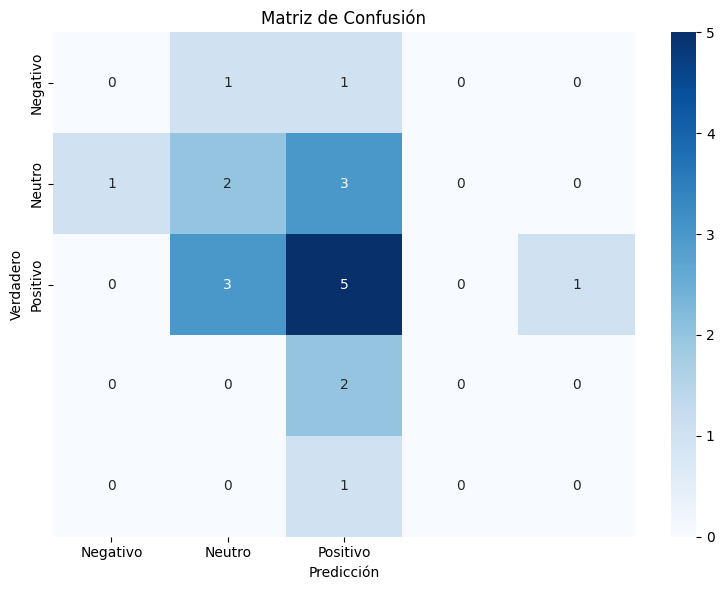

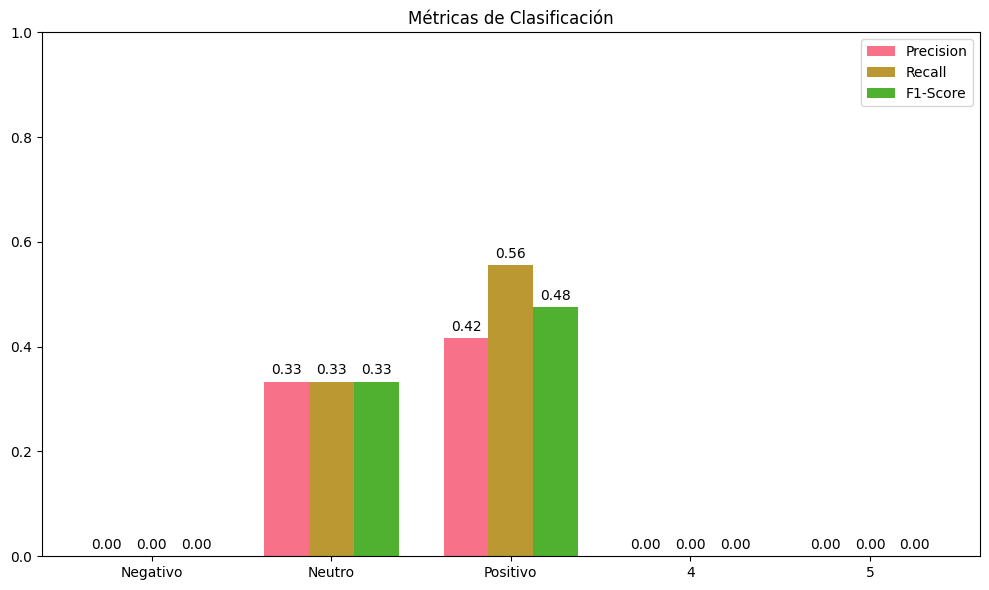


Resultados guardados en 'opiniones_tres_polaridades.csv'

=== VISUALIZACIÓN DE TODOS LOS SENTIMIENTOS ===


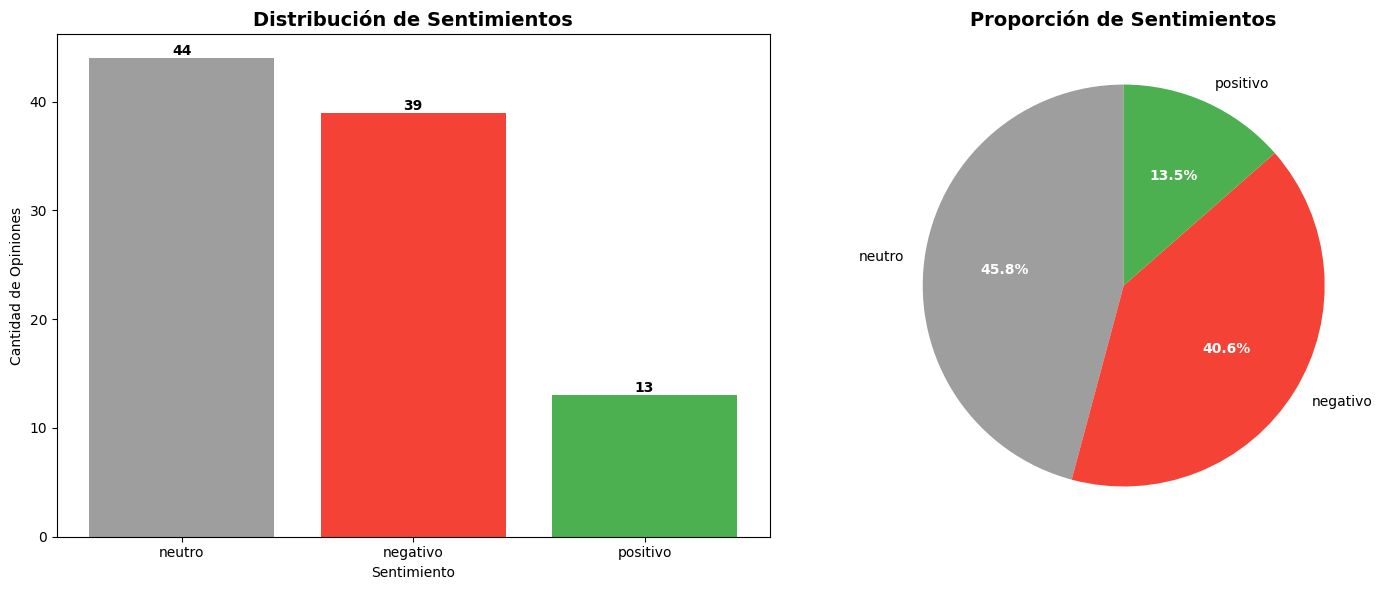


Estadísticas de sentimientos:
----------------------------------------
Neutro: 44 (45.8%)
Negativo: 39 (40.6%)
Positivo: 13 (13.5%)

=== VISUALIZACIÓN EXCLUYENDO SENTIMIENTOS NEUTROS ===


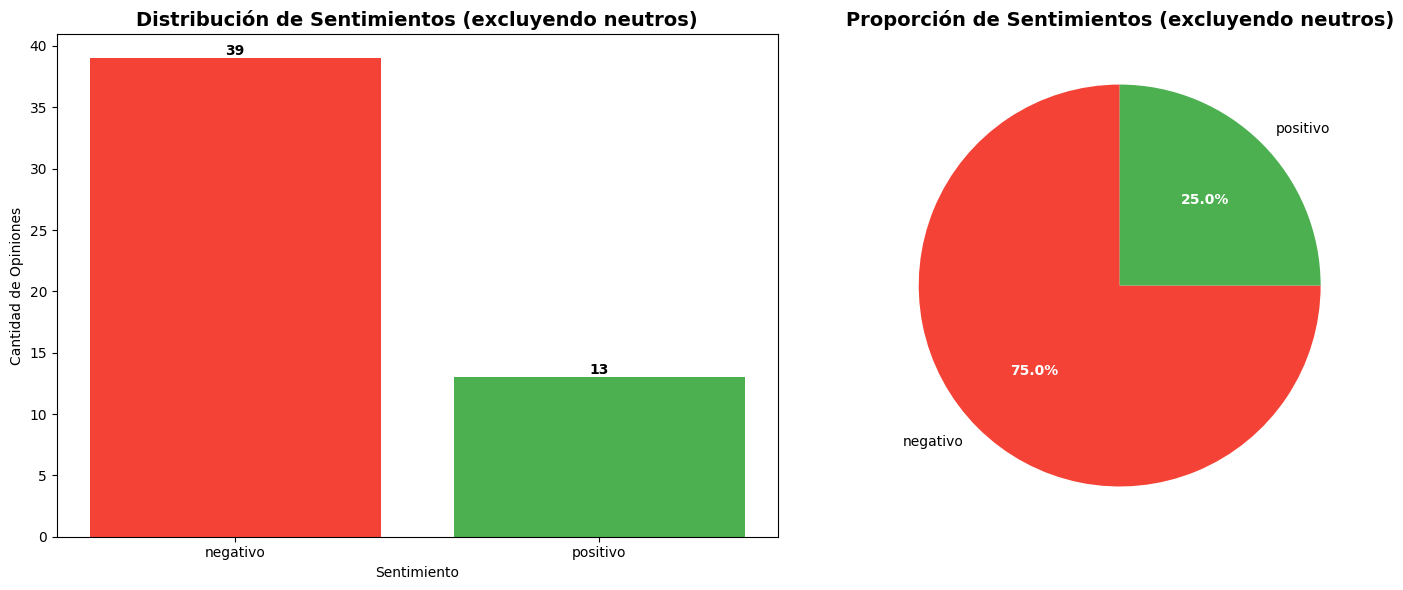


Estadísticas de sentimientos (excluyendo neutros):
----------------------------------------
Negativo: 39 (75.0%)
Positivo: 13 (25.0%)

ANÁLISIS DE ESTRELLAS
Total de respuestas: 96

Distribución por estrellas:
----------------------------------------
1 estrella ⭐:    9 (  9.4%)
2 estrellas ⭐⭐:   30 ( 31.2%)
3 estrellas ⭐⭐⭐:   44 ( 45.8%)
4 estrellas ⭐⭐⭐⭐:    7 (  7.3%)
5 estrellas ⭐⭐⭐⭐⭐:    6 (  6.2%)


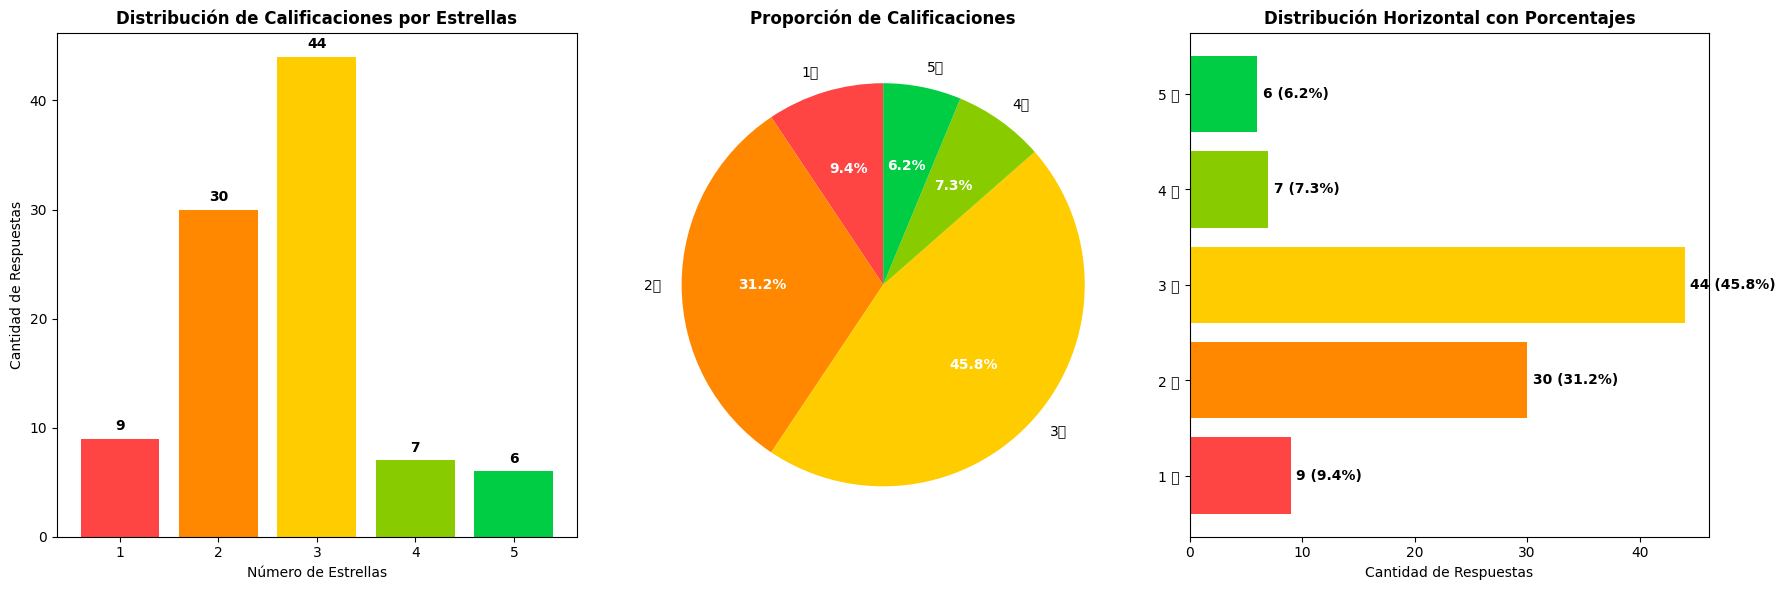


Análisis adicional:
----------------------------------------
Promedio de estrellas: 2.70
Mediana de estrellas: 3.0

Categorización:
Excelentes (4-5 ⭐): 13 (13.5%)
Regulares (3 ⭐): 44 (45.8%)
Malas (1-2 ⭐): 39 (40.6%)

Relación Estrellas vs Sentimiento:
----------------------------------------
sentimiento_predicho  negativo  neutro  positivo  All
rank                                                 
1                            9       0         0    9
2                           30       0         0   30
3                            0      44         0   44
4                            0       0         7    7
5                            0       0         6    6
All                         39      44        13   96

=== ANÁLISIS DE PALABRAS CLAVE POR SENTIMIENTO ===


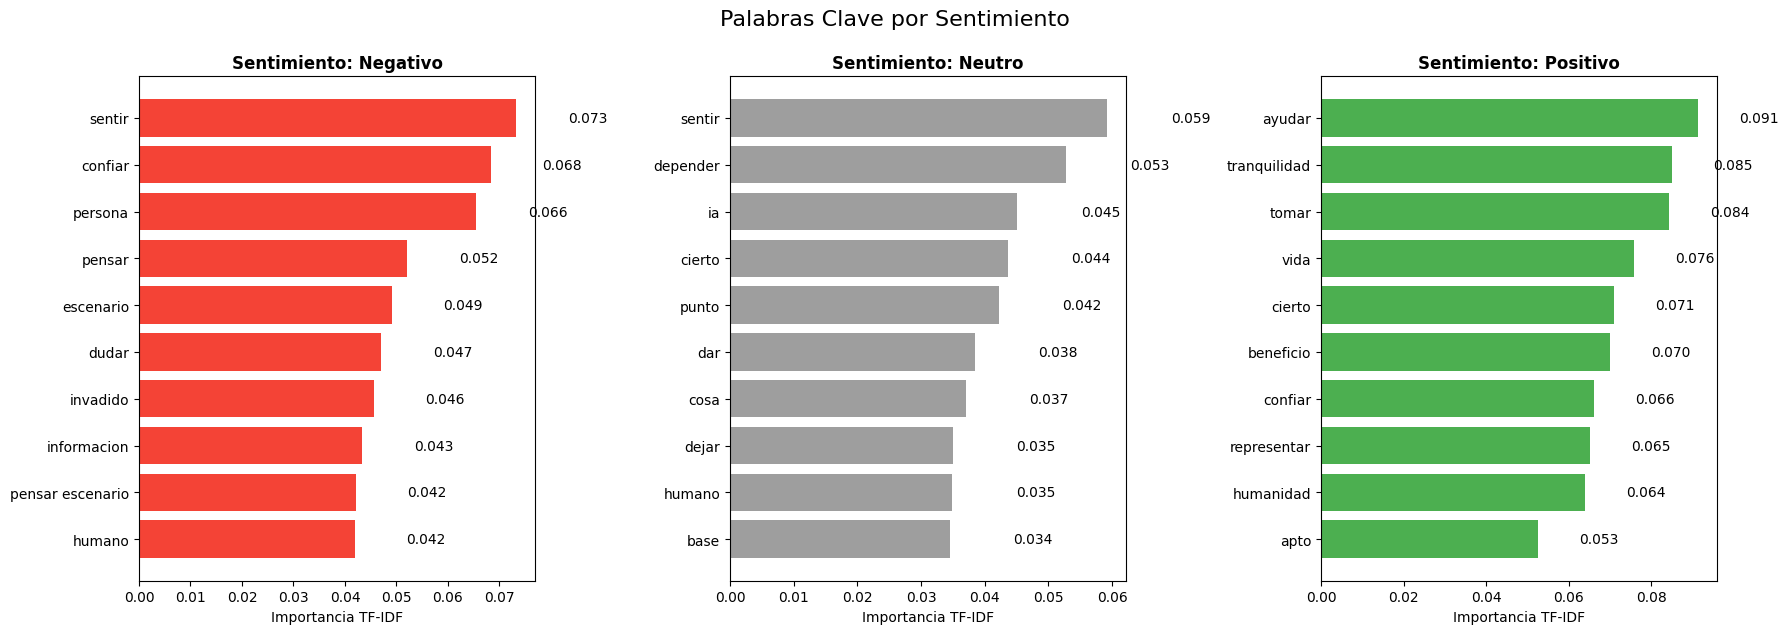


=== NUBES DE PALABRAS POR SENTIMIENTO ===


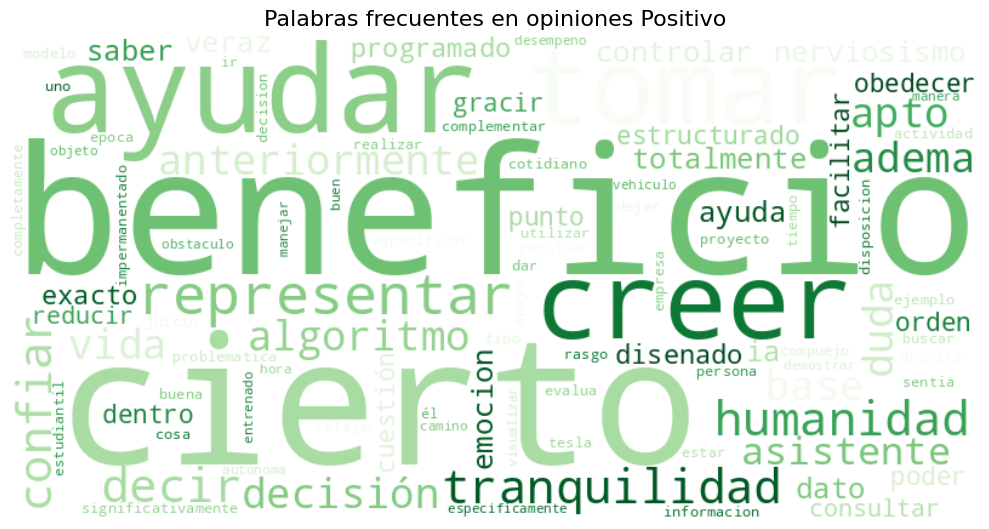

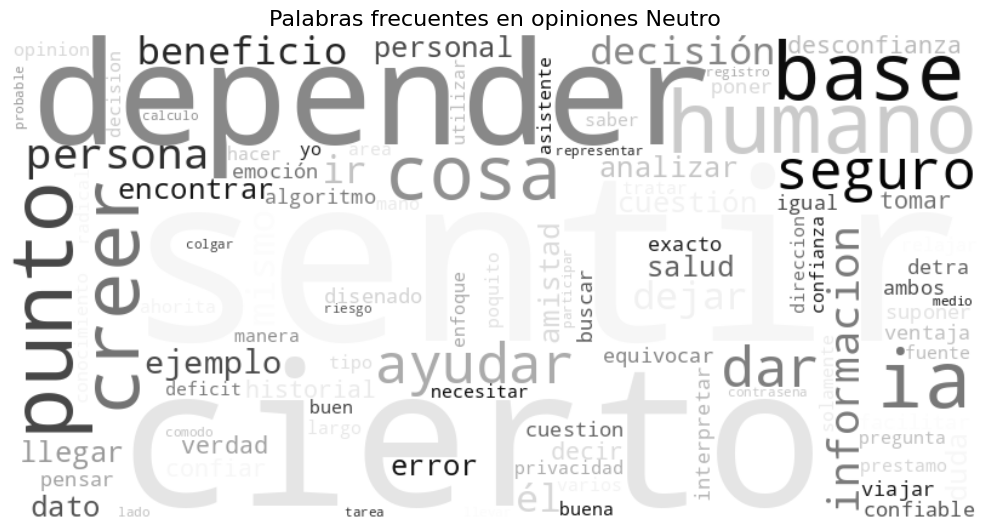

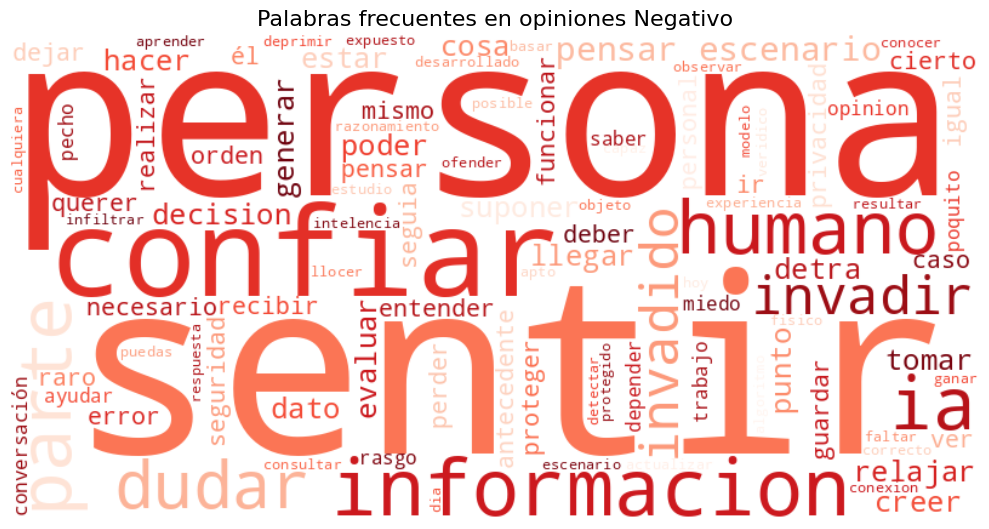


Modelo y vectorizador guardados correctamente

¡Análisis completo finalizado!


In [59]:
def ejecutar_analisis_completo():
    """
    Función principal que ejecuta todo el flujo de análisis
    """
    print("=== ANÁLISIS DE SENTIMIENTOS CON TRES POLARIDADES ===\n")

    # Cargar datos
    df = cargar_datos()
    if df is None:
        return None, None, None, None

    # Analizar sentimientos (tres polaridades)
    df = analizar_sentimiento_tres_polaridades(df)

    # Inicializar variables que podrían no asignarse en caso de error
    modelo, vectorizador, metricas = None, None, None

    # Verificar datos antes de continuar
    print("\n=== VERIFICACIÓN DE DATOS ===")
    if verificar_datos(df):
        print("Los datos están listos para el análisis.")
    else:
        print("Se encontraron problemas con los datos. Continuando con el análisis básico.")

    # Preparar features y entrenar modelo
    print("\n=== PREPARACIÓN DE CARACTERÍSTICAS Y ENTRENAMIENTO DE MODELO ===")
    try:
        X, y, vectorizador = preparar_features(df)
        if X is None:
            print("No se pudo preparar las características. Saltando entrenamiento del modelo.")
        else:
            modelo, metricas = entrenar_modelo(X, y)

            # Visualizar matriz de confusión y métricas
            print("\n=== VISUALIZACIÓN DE LA EVALUACIÓN DEL MODELO ===")
            visualizar_matriz_confusion(metricas['matriz_confusion'])
            visualizar_metricas_clasificacion(metricas['reporte'])
    except Exception as e:
        import traceback
        print(f"Error en la preparación de características o entrenamiento del modelo: {e}")
        print(traceback.format_exc())
        print("Continuando con el resto del análisis...")

    # Guardar resultados
    df.to_csv("opiniones_tres_polaridades.csv", index=False, encoding='utf-8-sig')
    print("\nResultados guardados en 'opiniones_tres_polaridades.csv'")

    # Visualizar resultados con todos los sentimientos
    print("\n=== VISUALIZACIÓN DE TODOS LOS SENTIMIENTOS ===")
    visualizar_sentimientos(df, incluir_neutro=True)

    # Visualizar resultados excluyendo neutros
    print("\n=== VISUALIZACIÓN EXCLUYENDO SENTIMIENTOS NEUTROS ===")
    visualizar_sentimientos(df, incluir_neutro=False)

    # Contabilizar estrellas
    contabilizar_estrellas(df)

    # Análisis de palabras clave por sentimiento
    print("\n=== ANÁLISIS DE PALABRAS CLAVE POR SENTIMIENTO ===")
    palabras_clave = identificar_palabras_clave_por_sentimiento(df)

    if palabras_clave:
        visualizar_palabras_clave(palabras_clave)

        # Generar nubes de palabras
        try:
            print("\n=== NUBES DE PALABRAS POR SENTIMIENTO ===")
            for sentimiento in ['positivo', 'neutro', 'negativo']:
                if sentimiento in df['sentimiento_predicho'].unique():
                    fig = generar_nube_palabras_sentimiento(df, sentimiento)
                    if fig:
                        plt.show()
        except Exception as e:
            print(f"No se pudieron generar las nubes de palabras: {e}")
            print("Instala wordcloud con: !pip install wordcloud")

    # Guardar modelo y vectorizador si no son None
    if modelo is not None and vectorizador is not None:
        try:
            import pickle
            with open('modelo_sentimiento.pkl', 'wb') as f:
                pickle.dump(modelo, f)
            with open('vectorizador_tfidf.pkl', 'wb') as f:
                pickle.dump(vectorizador, f)
            print("\nModelo y vectorizador guardados correctamente")
        except Exception as e:
            print(f"Error al guardar el modelo: {e}")

    print("\n¡Análisis completo finalizado!")
    return df, modelo, vectorizador, metricas

  # Ejecutar el análisis completo
df_analizado, modelo, vectorizador, metricas = ejecutar_analisis_completo()